<h1><center>Physique numérique (PHY-3500) - Projet final</center></h1>
<hr>
<br><br>

**Membres de l'équipe**
| Nom | NI |
| --- | :---: |
| Maxime Tousignant-Tremblay | 536 772 369 |
| Philippe Morin | 536 776 382 |
| Emilie Carré Smith| 111 235 839 |


In [2]:
import numpy as np
import skimage as ski
import imageio.v3 as imageio
from numpy.typing import NDArray
from matplotlib import pyplot as plt


%matplotlib inline
%config InlineBackend.figure_formats = "svg",
plt.style.use("LabReport.mplstyle")

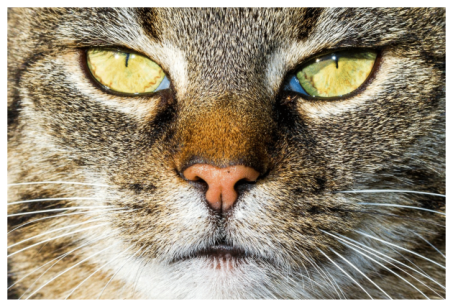

In [3]:
image = imageio.imread("cat.tiff")

plt.imshow(image)
plt.axis("off")
plt.show()

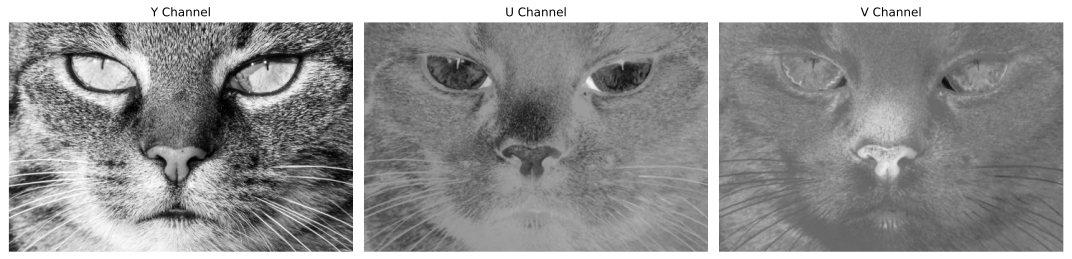

In [4]:
def rgb_to_yuv(rgb_image):  
    # Constantes pour la conversion RGB/YUV 
    transformation_matrix = np.array([
        [ 0.299,  0.587,    0.114],    # Coefficients for Y
        [-0.14713, -0.28886, 0.436],   # Coefficients for U
        [ 0.615, -0.51499, -0.10001]   # Coefficients for V
    ])
    

    flat_rgb = rgb_image.reshape((-1, 3))
    yuv_image = flat_rgb @ transformation_matrix.T  
    

    yuv_image = yuv_image.reshape(rgb_image.shape)
    return yuv_image

yuv_image = rgb_to_yuv(image)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(yuv_image[:, :, 0], cmap='gray')
plt.title('Y Channel')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(yuv_image[:, :, 1], cmap='gray')
plt.title('U Channel')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(yuv_image[:, :, 2], cmap='gray')
plt.title('V Channel')
plt.axis('off')

plt.show()

Ratio de compression : 0.10
Réduction de mémoire : 90.00%


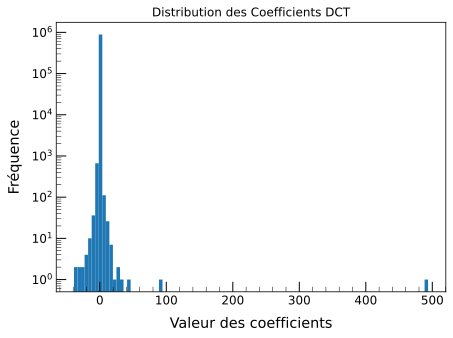

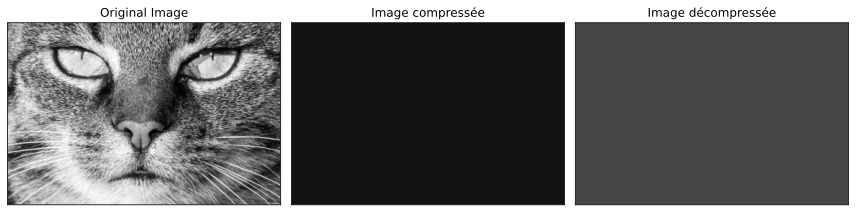

In [9]:
def init_dct_mat(N):
    """Crée une matrice de transformation DCT de taille N."""
    n = np.arange(N)
    k = np.arange(N).reshape(N, 1)
    facteur = np.pi * (2 * n + 1) / (2 * N)
    dct_mat = np.sqrt(2 / N) * np.cos(k * facteur)
    dct_mat[0] *= np.sqrt(0.5)
    return dct_mat


def compress_image(image_dct, ratio=0.1):
    """Compresse l'image en annulant les petits coefficients DCT."""
    # Calcul du seuil basé sur le quantile
    seuil = np.quantile(np.abs(image_dct), 1 - ratio)

    # Annulation des coefficients petits
    sig_coeffs = np.abs(image_dct) > seuil
    compr_img = image_dct * sig_coeffs
    compr_ratio = sig_coeffs.sum() / image_dct.size
    return compr_img, compr_ratio


# Charge une image et la convertit en niveaux de gris
img = ski.color.rgb2gray(ski.io.imread("cat.tiff"))
N, M = img.shape

# Création des matrices et application de la DCT
dct_mat_n = init_dct_mat(N)
dct_mat_m = init_dct_mat(M)
dct_img = dct_mat_n @ img @ dct_mat_m.T

# Compression de l'image et décompression via la DCT inverse
compr_img, compr_ratio = compress_image(dct_img, 0.1)
decompr_img = dct_mat_n.T @ img @ dct_mat_m

# Calcul de la réduction de mémoire
init_mem = img.size * img.itemsize
compr_mem = np.sum(compr_img != 0) * img.itemsize
mem_reduc = 100 * (1 - (compr_mem / init_mem))

# print(f"Image originale :\n {img}\n")
# print(f"Image après DCT et compression :\n {compr_img}\n")
# print(f"Image récupérée après décompression :\n {decompr_img}\n")
print(f"Ratio de compression : {compr_ratio:.2f}")
print(f"Réduction de mémoire : {mem_reduc:.2f}%")


plt.hist(dct_img.ravel(), bins=100, log=True)
plt.title("Distribution des Coefficients DCT")
plt.xlabel("Valeur des coefficients")
plt.ylabel("Fréquence")
plt.show()

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
axes[0].set_title("Original Image")
axes[0].imshow(img, cmap="gray")
axes[1].set_title("Image compressée")
axes[1].imshow(compr_img, cmap="gray")
axes[2].set_title("Image décompressée")
axes[2].imshow(decompr_img, cmap="gray")
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

Compression ratio: 0.10


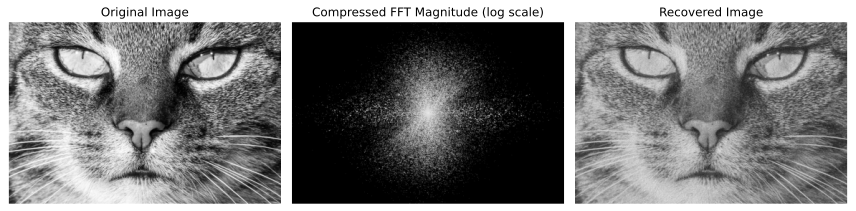

In [4]:
def compress_fft(img_fft, threshold_ratio=0.1):
    """Compresses the image by zeroing out small FFT coefficients."""
    mag = np.abs(img_fft)
    threshold = np.quantile(mag, 1 - threshold_ratio)
    sig = mag > threshold
    compr_fft = img_fft * sig
    compr_ratio = sig.sum() / img_fft.size
    return compr_fft, compr_ratio


# Read and convert an image to grayscale
img = ski.color.rgb2gray(ski.io.imread("cat.tiff"))
N, M = img.shape

# Apply FFT
fft_img = np.fft.fftshift(np.fft.fft2(img))

# Compress the image
compr_fft, compr_ratio = compress_fft(fft_img, threshold_ratio=0.1)
compr_fft_mag = np.log(np.abs(compr_fft) + 1e-10)

# Decompress the image
recovered_img = np.fft.ifft2(np.fft.ifftshift(compr_fft)).real
print(f"Compression ratio: {compr_ratio:.2f}")


# Plot the results
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
plt.imshow(img, cmap="gray")
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(compr_fft_mag, cmap="gray")
plt.title("Compressed FFT Magnitude (log scale)")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(recovered_img, cmap="gray")
plt.title("Recovered Image")
plt.axis("off")

plt.show()

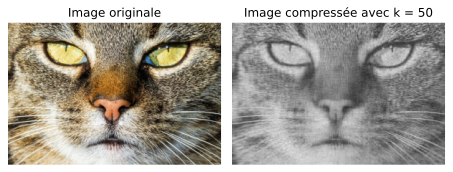

In [5]:
def svd_compress(image: NDArray, k: int) -> NDArray:
    """Compression d'image via SVD en gardant les k premières valeurs singulières.

    Paramètres
    ----------
        image
            Image en nuences de gris à compresser.
        k
            Nombre de valeurs singulières à garder.

    Retourne
    --------
        compr_image
            Approximation de l'image compressée.

    """
    # Algorithme SVD
    U, S, Vt = np.linalg.svd(image, full_matrices=False)

    # Matrices tronquées
    U_k = U[:, :k]
    S_k = np.diag(S[:k])
    Vt_k = Vt[:k, :]

    # Reconstruction
    # compr_image = np.dot(U_k, np.dot(S_k, Vt_k))
    compr_image = U_k @ (S_k @ Vt_k)
    return compr_image


# Lecture de l'image
image = ski.io.imread("cat.tiff")
gray_image = ski.color.rgb2gray(image)

k = 50  # Nombre de valeur singulière à garder
compr_img = svd_compress(gray_image, k)

plt.subplot(1, 2, 1)
plt.title("Image originale")
plt.imshow(image, cmap="gray")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Image compressée avec k = " + str(k))
plt.imshow(compr_img, cmap="gray")
plt.axis("off")
plt.show()

# Références

[1] Martin J. Berger *et al*. XCOM: Photon Cross Sections Database (Version 3.1). National Institute of Standards and Technology (NIST), 2010. URL : https://physics.nist.gov/PhysRefData/Xcom/html/xcom1.html. Page consultée le 12 avril 2024.